In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import math
import networkx as nx

### Import Environments

In [2]:
NUM_COUNTIES = 254          # Denotes the number of counties for reference

In [3]:
counties = [nx.read_shp(r'Texas\Env'+str(i)+'\edges.shp') for i in range(NUM_COUNTIES)]
counties_node_data = [nx.read_shp(r'Texas\Env'+str(i)+'\\nodes.shp') for i in range(NUM_COUNTIES)]

for i, C in enumerate(counties):
    for e in C.edges.data():
        if (e[1], e[0]) not in C.edges:
            C.add_edge(e[1], e[0])
        
            for A in e[2]:
                C[e[1]][e[0]][A] = e[2][A]
        
    for n in counties_node_data[i].nodes.data():
        for A in n[1]:
            C.nodes[n[0]][A] = n[1][A]

Here, we'll import a graph object containing connections between counties. This will be used by the county-to-county model.

In [4]:
county_connections_map = nx.read_shp(r'Texas\Counties\edges.shp')
county_connections_map_node_data = nx.read_shp(r'Texas\Counties\nodes.shp')

for e in county_connections_map.edges.data():
    if (e[1], e[0]) not in county_connections_map.edges:
        county_connections_map.add_edge(e[1], e[0])
        
        for A in e[2]:
            county_connections_map[e[1]][e[0]][A] = e[2][A]
        
for n in county_connections_map_node_data.nodes.data():
    for A in n[1]:
        county_connections_map.nodes[n[0]][A] = n[1][A]

Let's also extract the clusters of orphan wells for each county:

In [5]:
county_clusters = [[] for _ in range(NUM_COUNTIES)]
for i, C in enumerate(counties):
    for x in C.nodes.data():
        if 'well' in x[1]:
            if x[1]['well']=='1':
                county_clusters[i].append(tuple([x[0], x[1]['Size']])) # the size variable can be removed if unwanted
        
[len(C) for C in county_clusters]

[4,
 6,
 3,
 9,
 14,
 0,
 22,
 2,
 0,
 0,
 7,
 2,
 40,
 1,
 4,
 1,
 1,
 0,
 3,
 9,
 2,
 0,
 0,
 4,
 46,
 8,
 0,
 21,
 21,
 20,
 0,
 0,
 12,
 4,
 0,
 14,
 1,
 0,
 3,
 16,
 0,
 32,
 0,
 6,
 14,
 0,
 7,
 4,
 2,
 1,
 1,
 14,
 22,
 0,
 4,
 0,
 0,
 8,
 0,
 0,
 0,
 10,
 3,
 18,
 0,
 28,
 18,
 7,
 5,
 0,
 0,
 20,
 4,
 1,
 8,
 5,
 1,
 0,
 5,
 2,
 8,
 21,
 13,
 12,
 4,
 0,
 2,
 39,
 14,
 31,
 0,
 11,
 8,
 10,
 1,
 0,
 0,
 10,
 0,
 9,
 13,
 18,
 0,
 5,
 0,
 5,
 6,
 13,
 2,
 5,
 5,
 6,
 5,
 14,
 0,
 0,
 48,
 6,
 14,
 33,
 19,
 0,
 10,
 10,
 7,
 3,
 14,
 9,
 1,
 0,
 5,
 0,
 0,
 0,
 0,
 1,
 11,
 0,
 0,
 2,
 0,
 9,
 27,
 7,
 33,
 21,
 7,
 4,
 43,
 15,
 4,
 4,
 18,
 2,
 1,
 2,
 13,
 17,
 11,
 0,
 70,
 6,
 3,
 0,
 2,
 0,
 3,
 1,
 1,
 32,
 21,
 2,
 9,
 0,
 3,
 17,
 3,
 12,
 2,
 17,
 0,
 3,
 8,
 39,
 8,
 8,
 7,
 0,
 28,
 12,
 10,
 6,
 10,
 0,
 0,
 13,
 2,
 4,
 23,
 5,
 6,
 1,
 5,
 2,
 8,
 11,
 0,
 10,
 4,
 29,
 6,
 4,
 19,
 3,
 27,
 14,
 17,
 2,
 1,
 11,
 5,
 28,
 17,
 1,
 6,
 8,
 2,
 21,
 16,
 0,
 7,
 3

### Importing the Atascosa pather, DQN class, and methods

In [6]:
from DQN_Methods import DQN
from DQN_Methods import METHODS
import torch

In [7]:
county_model = torch.load('Models\Atascosa_Batch.pth')
county_model.eval()

DQN(
  (fc1): Linear(in_features=6, out_features=12, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=12, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Let's create the Method classes, which will facilitate the evaluation process for both individual counties, as well as the model between counties. We'll import the model trained from the Atascosa_Pathing_Algorithm notebook for all the models running within the counties.

In [8]:
M = [METHODS(counties[i], county_model, county_clusters[i]) for i in range(NUM_COUNTIES)]


inter_county_model = DQN()

temp = sorted([(n[1]['envNum'], n[0]) for n in county_connections_map.nodes.data()])
inter_county_cluster_rep = [(x[1], x[0], len(county_clusters[x[0]])) for x in temp if len(county_clusters[x[0]])>0]

M_state = METHODS(county_connections_map, inter_county_model, inter_county_cluster_rep)

inter_county_cluster_rep

[((-95.64304130738378, 31.8077861742029), 0, 4),
 ((-102.61099655621912, 32.312322740419724), 1, 6),
 ((-94.65732047750734, 31.282636033673814), 2, 3),
 ((-97.05098842281397, 28.05967093006565), 3, 9),
 ((-98.67969807850079, 33.62417972834022), 4, 14),
 ((-98.53873277057001, 28.954348686351995), 6, 22),
 ((-96.24484731745164, 29.85633705280225), 7, 2),
 ((-97.30502522993356, 30.12634878065931), 10, 7),
 ((-99.22750044443627, 33.57959570837839), 11, 2),
 ((-97.75858243901824, 28.418266172680713), 12, 40),
 ((-97.54176374317382, 31.075806351938375), 13, 1),
 ((-98.51239257008793, 29.479081769680732), 14, 4),
 ((-98.39658847022233, 30.206429370349365), 15, 1),
 ((-101.42635122436818, 32.719271355878156), 16, 1),
 ((-94.27840056375938, 33.44835603196039), 18, 3),
 ((-95.40685429321924, 29.271391213079593), 19, 9),
 ((-96.33206244476217, 30.64964634498329), 20, 2),
 ((-98.2099491637725, 27.069533021611935), 23, 4),
 ((-99.00155515058476, 31.76051049004826), 24, 46),
 ((-96.62301386230426, 3

Since inter_county_model is new, we'll need to train it.

In [9]:
SCORES = M_state.train()

Episode # 0
Optimal Path: [0, 120, 41, 62, 11, 144, 124, 83]
Learner Path: [0, 124, 83, 120, 62, 41, 144, 11]
Episode # 1
Optimal Path: [0, 107, 79, 167, 161, 150, 47, 163]
Learner Path: [0, 167, 79, 150, 107, 47, 161, 163]
Episode # 2
Optimal Path: [0, 153, 160, 172, 4, 74, 36, 156]
Learner Path: [0, 36, 160, 172, 4, 156, 153, 74]
Episode # 3
Optimal Path: [0, 55, 75, 181, 125, 9, 29, 28]
Learner Path: [0, 125, 9, 28, 75, 55, 181, 29]
Episode # 4
Optimal Path: [0, 106, 140, 128, 142, 61, 174, 68]
Learner Path: [0, 61, 140, 106, 128, 68, 174, 142]
Episode # 5
Optimal Path: [0, 26, 137, 115, 157, 193, 164, 158]
Learner Path: [0, 26, 115, 164, 158, 137, 193, 157]
Episode # 6
Optimal Path: [0, 81, 139, 14, 123, 8, 53, 140]
Learner Path: [0, 140, 139, 123, 14, 53, 81, 8]
Episode # 7
Optimal Path: [0, 50, 120, 153, 51, 45, 150, 58]
Learner Path: [0, 51, 153, 50, 120, 45, 58, 150]
Episode # 8
Optimal Path: [0, 14, 154, 20, 90, 1, 112, 30]
Learner Path: [0, 14, 1, 112, 90, 154, 20, 30]
Episod

Optimal Path: [0, 55, 152, 132, 15, 62, 18, 155]
Learner Path: [0, 55, 155, 18, 62, 15, 132, 152]
Episode # 76
Optimal Path: [0, 132, 97, 48, 136, 145, 42, 161]
Learner Path: [0, 132, 97, 48, 136, 42, 145, 161]
Episode # 77
Optimal Path: [0, 24, 102, 18, 180, 52, 61, 171]
Learner Path: [0, 24, 102, 171, 18, 180, 52, 61]
Episode # 78
Optimal Path: [0, 51, 20, 172, 82, 13, 147, 23]
Learner Path: [0, 51, 20, 172, 82, 147, 13, 23]
Episode # 79
Optimal Path: [0, 14, 50, 34, 100, 93, 33, 84]
Learner Path: [0, 14, 50, 34, 33, 84, 93, 100]
Episode # 80
Optimal Path: [0, 149, 186, 90, 192, 53, 1, 161]
Learner Path: [0, 149, 186, 90, 192, 1, 161, 53]
Episode # 81
Optimal Path: [0, 14, 130, 2, 186, 151, 29, 163]
Learner Path: [0, 14, 130, 2, 186, 151, 29, 163]
Episode # 82
Optimal Path: [0, 130, 54, 122, 84, 46, 42, 83]
Learner Path: [0, 130, 122, 54, 84, 46, 83, 42]
Episode # 83
Optimal Path: [0, 87, 107, 35, 86, 125, 146, 39]
Learner Path: [0, 87, 107, 86, 125, 35, 39, 146]
Episode # 84
Optimal

Episode # 150
Optimal Path: [0, 137, 113, 194, 102, 136, 185, 89]
Learner Path: [0, 137, 136, 185, 102, 194, 113, 89]
Episode # 151
Optimal Path: [0, 59, 160, 16, 10, 142, 96, 176]
Learner Path: [0, 16, 160, 59, 176, 96, 142, 10]
Episode # 152
Optimal Path: [0, 159, 25, 108, 123, 166, 143, 163]
Learner Path: [0, 123, 108, 25, 163, 159, 166, 143]
Episode # 153
Optimal Path: [0, 183, 51, 63, 180, 48, 4, 61]
Learner Path: [0, 183, 48, 4, 61, 180, 63, 51]
Episode # 154
Optimal Path: [0, 81, 15, 51, 95, 144, 109, 13]
Learner Path: [0, 81, 15, 95, 51, 144, 13, 109]
Episode # 155
Optimal Path: [0, 108, 153, 164, 146, 78, 98, 138]
Learner Path: [0, 138, 98, 78, 146, 164, 153, 108]
Episode # 156
Optimal Path: [0, 2, 31, 191, 172, 29, 142, 178]
Learner Path: [0, 2, 31, 191, 172, 29, 142, 178]
Episode # 157
Optimal Path: [0, 183, 164, 129, 120, 116, 23, 78]
Learner Path: [0, 129, 120, 183, 164, 78, 23, 116]
Episode # 158
Optimal Path: [0, 184, 129, 66, 7, 106, 57, 46]
Learner Path: [0, 129, 184, 

Optimal Path: [0, 173, 107, 148, 30, 64, 128, 89]
Learner Path: [0, 173, 107, 148, 30, 64, 89, 128]
Episode # 225
Optimal Path: [0, 59, 184, 172, 148, 136, 179, 165]
Learner Path: [0, 184, 59, 172, 148, 136, 179, 165]
Episode # 226
Optimal Path: [0, 173, 157, 127, 16, 19, 164, 78]
Learner Path: [0, 173, 127, 16, 164, 19, 157, 78]
Episode # 227
Optimal Path: [0, 159, 66, 100, 29, 134, 150, 142]
Learner Path: [0, 159, 66, 100, 29, 150, 134, 142]
Episode # 228
Optimal Path: [0, 71, 67, 134, 117, 37, 78, 30]
Learner Path: [0, 71, 67, 134, 37, 117, 78, 30]
Episode # 229
Optimal Path: [0, 100, 113, 80, 34, 53, 40, 46]
Learner Path: [0, 113, 100, 80, 34, 53, 40, 46]
Episode # 230
Optimal Path: [0, 65, 132, 21, 167, 83, 68, 58]
Learner Path: [0, 65, 132, 167, 68, 83, 58, 21]
Episode # 231
Optimal Path: [0, 154, 59, 15, 3, 20, 191, 196]
Learner Path: [0, 154, 191, 3, 15, 59, 20, 196]
Episode # 232
Optimal Path: [0, 104, 184, 123, 193, 155, 187, 43]
Learner Path: [0, 184, 123, 104, 193, 155, 187

Optimal Path: [0, 139, 123, 153, 152, 9, 175, 165]
Learner Path: [0, 139, 123, 152, 153, 9, 175, 165]
Episode # 299
Optimal Path: [0, 66, 21, 197, 120, 91, 128, 178]
Learner Path: [0, 197, 120, 91, 66, 21, 128, 178]
Episode # 300
Optimal Path: [0, 87, 194, 20, 114, 156, 99, 168]
Learner Path: [0, 194, 87, 20, 99, 168, 156, 114]
Episode # 301
Optimal Path: [0, 120, 184, 194, 19, 100, 78, 174]
Learner Path: [0, 184, 120, 19, 194, 100, 78, 174]
Episode # 302
Optimal Path: [0, 169, 180, 176, 39, 161, 1, 83]
Learner Path: [0, 169, 176, 180, 1, 83, 161, 39]
Episode # 303
Optimal Path: [0, 118, 71, 93, 163, 148, 78, 69]
Learner Path: [0, 118, 71, 93, 163, 148, 78, 69]
Episode # 304
Optimal Path: [0, 120, 123, 184, 81, 110, 187, 74]
Learner Path: [0, 81, 187, 110, 120, 184, 123, 74]
Episode # 305
Optimal Path: [0, 3, 7, 4, 128, 13, 174, 83]
Learner Path: [0, 7, 3, 128, 4, 13, 174, 83]
Episode # 306
Optimal Path: [0, 86, 72, 173, 34, 148, 73, 30]
Learner Path: [0, 72, 173, 86, 34, 148, 73, 30]


Optimal Path: [0, 113, 72, 136, 165, 28, 46, 155]
Learner Path: [0, 72, 155, 46, 28, 136, 165, 113]
Episode # 373
Optimal Path: [0, 149, 131, 88, 159, 33, 52, 64]
Learner Path: [0, 52, 64, 33, 159, 88, 131, 149]
Episode # 374
Optimal Path: [0, 70, 62, 94, 85, 42, 142, 1]
Learner Path: [0, 70, 62, 94, 85, 42, 142, 1]
Episode # 375
Optimal Path: [0, 133, 106, 29, 58, 28, 119, 64]
Learner Path: [0, 133, 106, 58, 28, 119, 64, 29]
Episode # 376
Optimal Path: [0, 164, 76, 163, 189, 45, 78, 23]
Learner Path: [0, 164, 76, 163, 45, 189, 78, 23]
Episode # 377
Optimal Path: [0, 104, 103, 67, 11, 22, 136, 135]
Learner Path: [0, 103, 67, 135, 136, 22, 104, 11]
Episode # 378
Optimal Path: [0, 24, 75, 16, 4, 84, 142, 112]
Learner Path: [0, 24, 16, 75, 142, 84, 4, 112]
Episode # 379
Optimal Path: [0, 132, 72, 175, 167, 92, 128, 47]
Learner Path: [0, 132, 72, 175, 167, 92, 128, 47]
Episode # 380
Optimal Path: [0, 120, 193, 104, 66, 113, 88, 90]
Learner Path: [0, 120, 193, 104, 66, 113, 90, 88]
Episode 

Learner Path: [0, 103, 45, 193, 53, 68, 13, 155]
Episode # 448
Optimal Path: [0, 80, 4, 8, 36, 23, 185, 155]
Learner Path: [0, 80, 4, 8, 36, 185, 155, 23]
Episode # 449
Optimal Path: [0, 181, 79, 167, 74, 147, 182, 44]
Learner Path: [0, 181, 79, 74, 147, 167, 182, 44]
Episode # 450
Optimal Path: [0, 2, 191, 32, 92, 84, 11, 17]
Learner Path: [0, 2, 191, 11, 17, 32, 92, 84]
Episode # 451
Optimal Path: [0, 102, 88, 71, 44, 170, 29, 175]
Learner Path: [0, 88, 102, 71, 170, 44, 29, 175]
Episode # 452
Optimal Path: [0, 157, 14, 66, 162, 60, 68, 111]
Learner Path: [0, 66, 162, 14, 157, 60, 68, 111]
Episode # 453
Optimal Path: [0, 55, 87, 71, 186, 21, 177, 180]
Learner Path: [0, 55, 87, 71, 186, 21, 177, 180]
Episode # 454
Optimal Path: [0, 25, 193, 128, 38, 1, 112, 83]
Learner Path: [0, 25, 193, 128, 38, 1, 112, 83]
Episode # 455
Optimal Path: [0, 149, 51, 17, 33, 146, 58, 53]
Learner Path: [0, 149, 51, 17, 33, 146, 58, 53]
Episode # 456
Optimal Path: [0, 130, 16, 91, 35, 47, 143, 165]
Learne

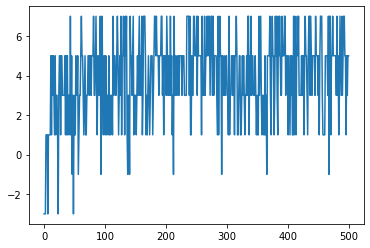

In [10]:
plt.plot(SCORES)

In [11]:
M_state.eval()

31.15869404022528
65.77982161323919
65.94702725940836
39.855084364365176
45.56433229150782
45.98048612292243
53.545621148807015
96.79914548064056
28.433764405129068
87.20362835467007
26.95581821431565
62.4278899791655
16.78126380384777
73.20287043473562
28.206182436004987
51.008763592170865
59.55700841330283
63.86161639631865
29.2905138769125
44.973677633471794
33.86307074942707
54.408985913582434
77.13128802161805
62.577079883349064
38.30469991921647
34.724446227422746
165.794970206258
108.92350215689275
48.73403020784082
92.42196860137449
120.2855985125223
32.72415354490637
44.252599478466195
73.93489608132057
98.35117363116278
68.92055205136565
70.07782479477545
33.88918371409927
65.60889549964975
52.89554661549794
61.45170840708223
29.364749599130416
44.22732217367364
69.78743811808276
98.07038373445253
24.556039684143574
55.8661526732979
29.508684833233783
56.68721631957246
83.05947651006595
35.26976965954333
61.12650809247276
61.38649905363239
24.328745021371436
59.72268654553593

(11164.393050217135,
 [0,
  26,
  115,
  130,
  108,
  113,
  87,
  88,
  131,
  137,
  24,
  14,
  72,
  184,
  123,
  149,
  65,
  197,
  153,
  70,
  25,
  59,
  103,
  2,
  129,
  154,
  55,
  118,
  15,
  186,
  3,
  168,
  76,
  140,
  95,
  176,
  17,
  110,
  97,
  89,
  163,
  44,
  90,
  133,
  21,
  54,
  71,
  132,
  152,
  194,
  164,
  86,
  125,
  106,
  9,
  158,
  6,
  160,
  159,
  81,
  139,
  173,
  80,
  50,
  120,
  157,
  183,
  66,
  31,
  62,
  182,
  99,
  43,
  187,
  57,
  93,
  41,
  100,
  162,
  102,
  75,
  16,
  51,
  63,
  170,
  5,
  177,
  67,
  20,
  101,
  19,
  56,
  94,
  104,
  127,
  7,
  191,
  107,
  49,
  151,
  11,
  188,
  96,
  156,
  146,
  117,
  39,
  124,
  178,
  161,
  171,
  174,
  28,
  112,
  138,
  69,
  111,
  105,
  195,
  126,
  83,
  119,
  23,
  74,
  64,
  165,
  68,
  98,
  58,
  1,
  37,
  46,
  147,
  78,
  53,
  179,
  40,
  185,
  190,
  155,
  38,
  47,
  122,
  12,
  169,
  181,
  77,
  10,
  91,
  34,
  193,
  172,

### Running through the clusters

In [12]:
START_NODE = 0

# Lambda functions used in DQN Methods
sq_dist = lambda n1, n2: (n1[0]-n2[0])**2 + (n1[1]-n2[1])**2

# This function looks through the nodes of component |comp| and finds the closest point to |N|
# Input: component searching through |comp| and node we're approaching |N|
# Returns: (distance, node)
find_closest = lambda comp, N: min([(sq_dist(N, n), n) for n in comp])

TOTAL_PATH = []

actions = [i for i in range(len(inter_county_cluster_rep))]
actions.remove(START_NODE)
state = (START_NODE, [START_NODE], actions, 0)

while state!=None:
    # Once at a county, run the county_model on it
    G = M[inter_county_cluster_rep[state[0]][1]]
    
    if state[0]!=START_NODE:
        # Connect to closest point on new graph
        TOTAL_PATH.append(find_closest(G.Map.nodes, TOTAL_PATH[-1])[1])
        closest_cluster = find_closest([x[0] for x in G.clusters], TOTAL_PATH[-1])[1]
        G.START_NODE = [i for i, c in enumerate(G.clusters) if c[0]==closest_cluster][0]
    
    for a in G.eval(verbose=0)[1]:
        # Add all clusters that the county_model visits in order
        TOTAL_PATH.append(G.clusters[a][0])
    
    
    # Decide which county to go to next
    action = M_state.select_action(state, opt=True)
    
    D = M_state.DISTANCE_TABLE[state[0], action]
    # Update the current state
    state = (action, state[1]+[action], state[2], state[3]+D)
    
    if len(state[2])==0:
        state = None
    
TOTAL_PATH

4
1
17
3
4
2
19
10
12
8
4
3
18
6
1
5
11
52
2
9
14
12
21
3
17
8
2
6
9
19
9
11
13
28
5
21
4
18
11
10
27
28
7
17
21
5
13
2
5
4
14
33
21
43
40
29
2
4
6
5
7
6
6
1
2
4
14
8
14
39
22
9
18
24
21
9
10
27
3
33
6
2
8
14
28
22
16
10
21
7
8
8
1
7
9
7
23
15
4
1
4
12
1
10
2
70
4
32
7
19
17
8
16
1
8
10
2
4
5
2
48
3
12
5
31
17
1
2
13
6
14
7
4
5
1
3
8
2
1
11
22
5
1
1
5
1
2
1
3
2
2
1
11
5
1
20
13
14
3
2
1
6
1
1
2
14
2
7
12
23
5
3
4
1
14
2
3
10
6
10
9
8
6
5
4
14
39
18
20
13
3
6
3
4
4
3
32


[(-95.47383183, 31.806948714999997),
 (-95.45763415, 31.802037374999998),
 (-95.71998791, 31.95961067),
 (-95.48557947000002, 31.62749869565217),
 (-95.39338052118543, 31.764092590736634),
 (-94.59100587092608, 31.973049736115918),
 (-94.57989927, 31.98246362),
 (-94.57922859, 32.09945251),
 (-94.592792225, 32.080390095),
 (-94.53121510333334, 32.10970281666667),
 (-94.49102376, 32.22348312),
 (-94.54636622, 32.24959025),
 (-94.3518524, 32.31604571),
 (-94.3442538, 32.3018249),
 (-94.07877823, 32.33096083),
 (-94.05803662, 32.34617206),
 (-94.06926667, 32.36424997),
 (-94.09087561, 32.18567819),
 (-94.043909605, 32.14413569),
 (-94.058525745, 32.070414490000005),
 (-94.185482235, 32.0691669),
 (-94.30489458, 32.11039795),
 (-94.35113398, 32.03094915),
 (-93.98364207206613, 31.565741037405523),
 (-93.74199046, 31.24376843),
 (-93.75719567, 31.18435892),
 (-93.72811771, 31.2249933),
 (-93.72619910521416, 31.168602085360643),
 (-93.62119025, 31.16994327),
 (-93.702776, 30.68121265),
 (-93

0.0
0.0
0.00218435998252512
0.00436871996505024
0.00655307994757536
0.00873743993010048
0.010921799912625601
0.01310615989515072
0.01529051987767584
0.01747487986020096
0.019659239842726082
0.021843599825251202
0.024027959807776323
0.02621231979030144
0.02839667977282656
0.03058103975535168
0.0327653997378768
0.03494975972040192
0.03713411970292704
0.039318479685452164
0.041502839667977284
0.043687199650502405
0.045871559633027525
0.048055919615552646
0.05024027959807777
0.05242463958060288
0.054608999563128
0.05679335954565312
0.05897771952817824
0.06116207951070336
0.06334643949322849
0.0655307994757536
0.06771515945827872
0.06989951944080385
0.07208387942332896
0.07426823940585409
0.0764525993883792
0.07863695937090433
0.08082131935342944
0.08300567933595457
0.08519003931847968
0.08737439930100481
0.08955875928352992
0.09174311926605505
0.09392747924858016
0.09611183923110529
0.0982961992136304
0.10048055919615553
0.10266491917868065
0.10484927916120576
0.10703363914373089
0.1092179

0.9305373525557011
0.9327217125382263
0.9349060725207514
0.9370904325032765
0.9392747924858017
0.9414591524683268
0.9436435124508519
0.9458278724333771
0.9480122324159022
0.9501965923984272
0.9523809523809523
0.9545653123634775
0.9567496723460026
0.9589340323285277
0.9611183923110529
0.963302752293578
0.9654871122761031
0.9676714722586283
0.9698558322411533
0.9720401922236784
0.9742245522062036
0.9764089121887287
0.9785932721712538
0.9807776321537789
0.9829619921363041
0.9851463521188292
0.9873307121013543
0.9895150720838795
0.9916994320664045
0.9938837920489296
0.9960681520314548
0.9982525120139799


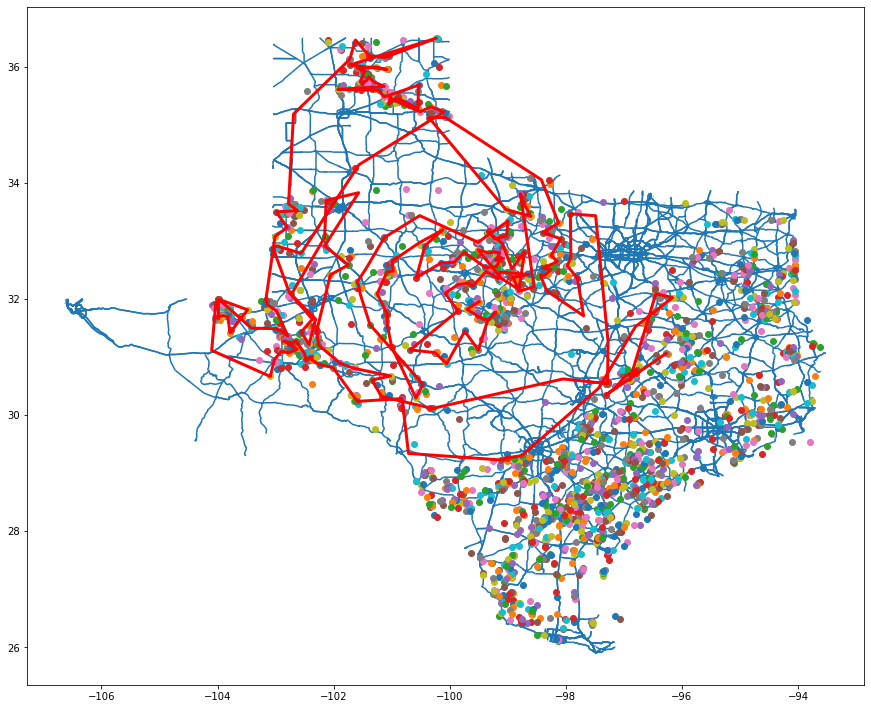

In [23]:
import matplotlib.animation as animation

# Basemap will be the background (road map) of the animation
basemap = gpd.read_file(r'Maps\Texas\tl_2020_48_prisecroads.shp')

fig, ax = plt.subplots(figsize=(15,15))
xs = []
ys = []
line, = ax.plot(xs, ys, color='r', linewidth=3)

basemap.plot(ax=ax, figsize=(15,15), zorder=0)

for CC in county_clusters:
    for n in CC:
        plt.scatter(n[0][0], n[0][1])#, s=25*C[1])

# This function is called periodically from FuncAnimation
def animate(i, xs=xs, ys=ys):
     # Add x and y to lists
    print(i/len(path_x))
    xs.append(path_x[i])
    ys.append(path_y[i])

    # Limit x and y lists
    xs = xs[-200:]
    ys = ys[-200:]

    line.set_data(np.array(xs), np.array(ys))
    
    return line,

# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(fig, animate, frames=list(range(0, len(path_x), 5)) )
ani.save('Gifs\Texas_batch.gif', fps=15)